In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

In [ ]:
"""
 The python script to solve the Cahn-Hilliard equation that uses Forward Time Central Space(FTCS) method
 
"""
# Author: Wentao Gong
# Github: @wentaogong111


In [2]:
# Parameters
Nx, Ny = 100, 100
dx = 1.0
dt = 0.01
M = 1.0
kappa = 0.02
Nt = 200
L = np.sqrt(Nx * Ny)

# Boundary condition
boundary_condition = 'Neumann'#Dirichlet, Neumann,Periodic

# Initialize
rng = np.random.default_rng(12345)
noise = 0.1
c0 = 0.5
c = c0 + noise * rng.standard_normal((Nx, Ny))
mu = np.zeros((Nx, Ny))
c_list = [c.copy()]


# Finite Difference Method:Forward Time Central Space(FTCS),Explicit 
$$ \frac{c_{n+1}-c_{n}}{\Delta t}= M\nabla^2\mu $$

$$ 
\mu = c^3-c-\kappa\nabla^2c
$$ 

$$
\nabla^2\mu = \frac{\mu_{i+1,j}-2\mu_{i,j}+\mu_{i-1,j}}{(\Delta x)^2}+\frac{\mu_{i,j+1}-2\mu_{i,j}+\mu_{i,j-1}}{(\Delta y)^2}
$$

$$ 
\Delta x = \Delta y 
$$

$$
c_{i,j}^{n+1}=c_{i,j}^{n}+\frac{\Delta t M}{(\Delta x)^2}(\mu_{i+1,j}+\mu_{i-1,j}+\mu_{i,j+1}+\mu_{i,j-1}-4\mu_{i,j})
$$

$$ 
\mu_{i,j} = (c_{i,j}^{n})^3-c_{i,j}^{n}-\frac{\kappa}{(\Delta x)^2}(c_{i+1,j}+c_{i-1,j}+c_{i,j+1}+c_{i,j-1}-4c_{i,j})
$$
## Note

The FTCS scheme is conditionally stable for certain types of problems. The stability condition for diffusion equation is $\alpha \frac{\Delta t}{\Delta x^2} \le \frac{1}{2}$

 However, the presence of nonlinear terms and additional components related to $\kappa$ and $c^3$ complicates the stability condition.

## Calculations Steps 
Main loop for time evolution
1. Update $\mu$ field based on current c field on the domain 

 $$ 
\mu_{i,j} = (c_{i,j}^{n})^3-c_{i,j}^{n}-\frac{\kappa}{(\Delta x)^2}(c_{i+1,j}+c_{i-1,j}+c_{i,j+1}+c_{i,j-1}-4c_{i,j})
$$

 2. Update c field based on $\mu$ field on the domian

$$ 
\nabla^2\mu = \frac{\mu_{i+1,j}-2\mu_{i,j}+\mu_{i-1,j}}{(\Delta x)^2}+\frac{\mu_{i,j+1}-2\mu_{i,j}+\mu_{i,j-1}}{(\Delta y)^2}
$$


$$
c_{i,j}^{n+1}=c_{i,j}^{n}+\frac{\Delta t M}{(\Delta x)^2}(\mu_{i+1,j}+\mu_{i-1,j}+\mu_{i,j+1}+\mu_{i,j-1}-4\mu_{i,j})
$$

3. Store the updated c field



# Boundary Conditions in Cahn-Hilliard Simulation


## 1. Periodic Boundary Conditions

Periodic boundary conditions wrap the grid around such that the first and last elements are identical. Mathematically, this can be represented as:

$$
c_{0,j} = c_{\text{Nx}-1,j} \quad \text{and} \quad c_{i,0} = c_{i,\text{Ny}-1}
$$

## 2. Neumann Boundary Conditions

For Neumann boundary conditions, the spatial derivative at the boundary is specified. The simplest form is zero flux, i.e., no change at the boundary. Mathematically, for a zero-flux condition, this can be represented as:

$$
\frac{\partial c}{\partial x} \Bigg|_{x=0} = \frac{\partial c}{\partial x} \Bigg|_{x=\text{Nx}} = 0
$$

$$
\frac{\partial c}{\partial y} \Bigg|_{y=0} = \frac{\partial c}{\partial y} \Bigg|_{y=\text{Ny}} = 0
$$

In discretized terms, this could be interpreted as:

$$
c_{0,j} = c_{1,j} \quad \text{and} \quad c_{\text{Nx}-1,j} = c_{\text{Nx}-2,j}
$$

$$
c_{i,0} = c_{i,1} \quad \text{and} \quad c_{i,\text{Ny}-1} = c_{i,\text{Ny}-2}
$$

## 3. Dirichlet Boundary Conditions

For Dirichlet boundary conditions, you specify the exact value at the boundary, like some constant \( c_0 \).

$$
c_{0,j} = c_{\text{Nx}-1,j} = c_0
$$

$$
c_{i,0} = c_{i,\text{Ny}-1} = c_0
$$



In [3]:
def update_fields(c, mu, dx, dt, M, kappa, boundary_condition):
    Nx, Ny = c.shape
    
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            laplacian_c = (c[i + 1, j] + c[i - 1, j] + c[i, j + 1] + c[i, j - 1] - 4 * c[i, j]) / dx ** 2
            mu[i, j] = c[i, j] ** 3 - c[i, j] - kappa * laplacian_c

    # Boundary conditions
    if boundary_condition == 'Dirichlet':
        c[0, :] = 0.5
        c[-1, :] = 0.5
        c[:, 0] = 0.5
        c[:, -1] = 0.5
    elif boundary_condition == 'Neumann':
        c[0, :] = c[1, :]
        c[-1, :] = c[-2, :]
        c[:, 0] = c[:, 1]
        c[:, -1] = c[:, -2]
    elif boundary_condition == 'Periodic':
        c[0, :] = c[-1, :]
        c[-1, :] = c[0, :]
        c[:, 0] = c[:, -1]
        c[:, -1] = c[:, 0]
        
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            laplacian_mu = (mu[i + 1, j] + mu[i - 1, j] + mu[i, j + 1] + mu[i, j - 1] - 4 * mu[i, j]) / dx ** 2
            c[i, j] += dt * M * laplacian_mu


c =  0.5359753505964565
relative_error =  0.0716003744937415


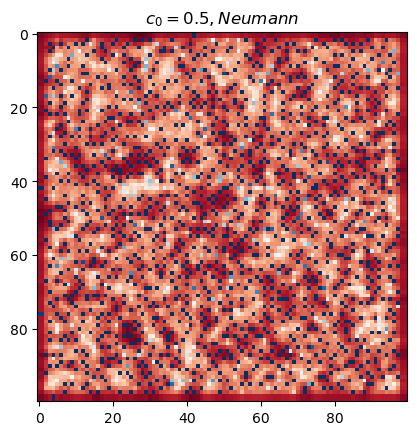

201


In [4]:
# Time Evolution
for t in range(Nt):
    update_fields(c, mu, dx, dt, M, kappa, boundary_condition)
    c_list.append(c.copy())
# Relative Error Calculation
print('c = ', c.sum() * dx ** 2 / L ** 2)
print('relative_error = ', np.abs(c.sum() - c_list[0].sum()) / c_list[0].sum())
plt.imshow(c, cmap='RdBu_r', vmin=0.0, vmax=1.0)
plt.title(f'$c_0={c0:.1f},{boundary_condition}$')
plt.savefig(f'cahn-hilliard-c0-{c0:.1f},{boundary_condition}.png')
plt.show()
print(len(c_list))

NameError: name 'c_list' is not defined

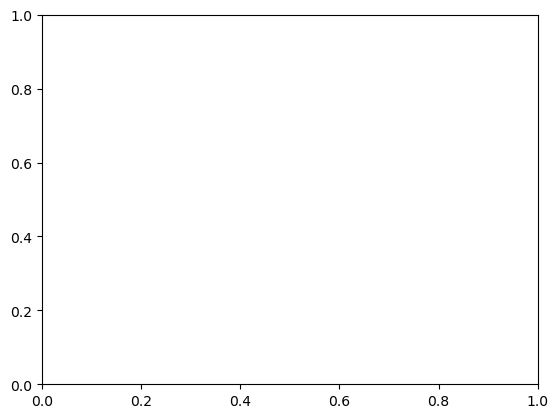

In [1]:
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.pyplot as plt

# Assumed initial parameters (replace with your actual parameters)
# c_list, Nt, dt, c0, boundary_condition

fig, ax = plt.subplots()
im = ax.imshow(c_list[0], cmap='RdBu_r', vmin=0.0, vmax=1.0)
cb = plt.colorbar(im)
cb.set_label(r'$c(x,y)$')

# Set an initial title
ax.set_title(f'c0 = {c0}, t = 0, {boundary_condition}')

def animate(i):
    im.set_data(c_list[i])
    im.set_clim(0.0, 1.0)
    
    # Update the title to reflect the current time
    ax.set_title(f'c0 = {c0}, t = {i * dt:.2f}, {boundary_condition}')
    
    return [im]

ani = FuncAnimation(fig, animate, frames=Nt, interval=200, blit=True)

# Output as .gif
writer_gif = PillowWriter(fps=24)
ani.save(f"bc-c0-{boundary_condition}_{c0}.gif", writer=writer_gif)
